# Kelp Project

### Tanner Thompson - Math 403 - 12/8/16

In [217]:
%matplotlib inline
import spectral as spy
import spectral.io.envi as envi
import numpy as np
import os
import subprocess
from matplotlib import pyplot as plt

## Research Question and Overview

This summer, I spent eight weeks doing research with the NASA Student Airborne Research Program. I joined a group of students researching remote sensing of the coastal ocean. I decided to study the kelp forests along the California coasts, and in particular, I decided to tackle the problem of distinguishing between kelp species in remote sensing imagery.

A fully automated solution to this problem has never been put forth.  Rather, ocean scientists have used spotter planes to personally fly over areas of kelp forests and identify the species with the naked eye.  This is rather expensive and time consuming.  Satellite imagery, such as that from Landsat (a family of NASA satellites), has been tried, but does not have high enough resolution to resolve structural differences in the kelp species.  It also does not afford enough data on a per-pixel level to positively differentiate between the reflectance spectra of the two species

However, as far as the literature suggested, no one had ever attempted this problem with hyperspectral imagery, which is what I decided to bring to the table along with my math and coding skills.  The term "hyperspectral" refers to imagery with a large number of bands.  Landsat has 7 bands, which, while certainly better than a standard camera, are not considered hyperspectral.

My data comes from a hyperspectral sensor called AVIRIS (Airborne Visual-Infrared Imaging Spectrometer). AVIRIS is an airborne instrument operated by NASA. It images the ground at 224 different wavelengths spanning from ultraviolet to long infrared. This allows scientists to see the brightness of each pixel across the spectrum. For example, here's the spectrum of a kelp bed in Carmel Bay, California, taken on April 10th, 2010:

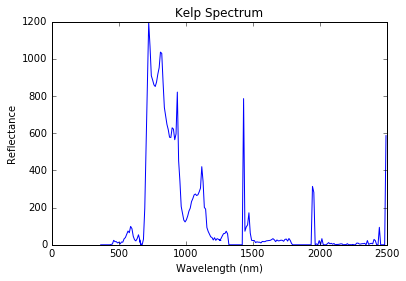

In [280]:
filename = './unpacked_tars/f130410t01p00r09_refl/f130410t01p00r09rdn_refl_img_corr'
img = envi.open(filename + '.hdr', filename)
kelp = img.read_pixel(1150,500)
plt.plot(img.bands.centers, kelp)
plt.title('Kelp Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

My conjecture was, and is, that by using hyperspectral data, the spectra of different kinds of kelp can be differentiated.  This has been successfully demonstrated in other plant species and ground cover types, and is grounded in the idea that different species have different chemical makeup, which translates into different spectral signatures.

During those eight weeks in the summer, I wrote two elementary algorithms that were essentially subtle variants on the K-Nearest-Neighbors algorithm with k=1.  In other words, they were pretty rudimentary.  I also only had about 60 data points to work with, because I was selecting the kelp by hand.  Despite those restrictions, my initial results suggested that my classification had about 80% accuracy.  This strengthened my confidence in my initial conjecture.  In addition, my reseach advisor Dr. Raphe Kudela, was very excited and encouraged me to continue the research.

In this project, I aim to 1) collect orders of magnitude more data points by automating the kelp-finding process, and 2) use better machine-learning algorithms to decrease the runtime and increase the accuracy of the classification process. I will treat the first objective in this project, whereas the second objective will be pursued in next semester's project.

In order to train the algorithm, I need some data points for which I already know the species.  Over the summer, I researched the two species of kelp found on the coast of California, bull kelp and giant kelp.  I learned from survey data that bull kelp is virtually never found south of Point Conception, and giant kelp is rarely found north of San Francisco.  Thus, by knowing the latitute of the kelp pixels I gather, I can filter out the northernmost pixels to use as bull kelp training data, and likewise the southernmost as giant kelp.

A fully automated solution to this problem will make the mapping of California kelp forests orders of magnitude easier.  Kelp forests are the backbone of the near-shore ecosystem, so this data will be valuable to marine biologists.  In addition, since the two species have different water temperature preferences, climate scientists will be able to use the distribution of kelp species as an indicator of climate change.

## Data Cleaning!

First, we need to define a method to convert from image coordinates to earth coordinates.

In [187]:
def coords(img,x,y):
    """
    Accepts:
        img: a SpyFile object
        x, y: the pixel coordinates (zero-based indexing)
        
    Returns:
        e, n: the UTM coordinates
        z: the UTM zone
        
    Note: the code now accounts for rotation!
    """
    info = img.metadata['map info']
    
    # check the metadata to make sure the format is supported 
    if info[0] != 'UTM':
        raise ValueError('Coordinate generation is only built for UTM, not ' + info[0])
    if info[1] != '1':
        raise ValueError('this should be 1')
    if info[2] != '1':
        raise ValueError('this should be 1')
    if not info[-1].startswith('rotation'):
        raise ValueError('No rotation angle found')
    
    # name some variables to make the code more readable
    easting = float(info[3])
    northing = float(info[4])
    x_pixel_size = float(info[5])
    y_pixel_size = float(info[6])
    utm_zone = int(info[7])
    exec(images[i].metadata['map info'][-1]) # rotation = <rotation angle>
    rotation *= np.pi/180 # convert rotation angle to radians
    
    # do some trigonometry
    # account for the rotation of the image
    new_easting = easting + x*x_pixel_size*np.cos(rotation) + y*y_pixel_size*np.sin(rotation)
    new_northing = northing - y*y_pixel_size*np.cos(rotation) + x*x_pixel_size*np.sin(rotation)
    return new_easting, new_northing, utm_zone

The AVIRIS data comes in a .tar.gz file, which needs to be unzipped.  This code unzips any images that haven't already been unzipped.

In [ ]:
unpacked_flight_names = map(lambda s: s[:s.index('_')],os.listdir('./unpacked_tars/'))
packed_flight_names = map(lambda s: s[:s.index('_')],os.listdir('./raw_AVIRIS_files/'))

for flight_name in packed_flight_names:
    if flight_name not in unpacked_flight_names:
        print 'unpacking', flight_name
        subprocess.call('tar -xvzf ./raw_AVIRIS_files/' + flight_name + '_refl.tar.gz -C ./unpacked_tars/', shell = True)

Finally, we're ready to do some data processing.  To open the AVIRIS image files, we'll use a package called Spectral Python, which was built for opening and visualizing hyperspectral images.

This code opens each image file as a SpyFile object, instead of just a numpy array, because of the size of the file.  This class allows you to read one band or one pixel at a time to avoid loading the entire image (sometimes over 10GB) into the memory at once.

After opening the images, we read in certain important bands. These will be used in identifying the kelp and later in visualization.

The brightness values in the data are dimensionless, as they are the ratio of reflected radiation intensity to received radiation intensity.  Since this gives only values between 0 and 1, the final values have been scaled by a factor of 10000.

We identify the kelp through several different criteria.  First, we calculate the NDVI (Normalized Difference Vegetation Index). High NDVI values can indicate vegetation, but can also indicate a pixel with a zero in the red band (560 nm). To correct for that, we rule out any pixels with a reflectance value less than 40 in the SWIR 1 band (Shortwave Infrared, 1102 nm).  This eliminates virtually all ocean pixels, since water reflects almost no SWIR radiation. Next, we rule out any pixels with a reflectance value greater than 600 in the SWIR 1 band, which eliminates all but the darkest vegetation on land.  Finally, we throw out any remaining pixels with a green reflectance value of less than 60, which gets rid of the rest of the land vegetation.  Thus, we are left with ocean vegetation, which is exclusively kelp.

Once the pixels have been identified, their reflectance vectors are stored in master_pixel_list.

In [194]:
unpacked_flight_names = sorted(map(lambda s: s[:s.index('_')],os.listdir('./unpacked_tars/')))
if 'f130410t01p00r11' in unpacked_flight_names:
    unpacked_flight_names.remove('f130410t01p00r11')
    
master_pixel_list = []
master_coord_list = []
images = []
for i, flight_name in enumerate(unpacked_flight_names):

    # reads in the image
    print 'reading in', flight_name
    filename = './unpacked_tars/' + flight_name + '_refl/' + flight_name + 'rdn_refl_img_corr'
    images.append(envi.open(filename + '.hdr', filename))

    # grabs all the necessary bands and calculates NDVI (normalized difference vegetation index)
    print 'grabbing bands'
    kelpgreen = images[i].read_band(23).astype(float)
    red = images[i].read_band(33).astype(float)
    nir = images[i].read_band(39).astype(float)
    nir2 = images[i].read_band(59).astype(float)
    swir1 = images[i].read_band(78).astype(float)
    swir2 = images[i].read_band(137).astype(float)
    NDVI = ((nir - red)/(nir + red))
    NDVI[np.isnan(NDVI)] = -1
    ratio = nir2/nir

    # here's the magic
    # uses the following criteria to pick the kelp out

    # NDVI == 1 grabs only the most vegetated areas (but also inadverently grabs places where red just is zero)
    # swir1 > 40 gets rid of random pixels in the ocean that have red == 0
    # swir1 < 600 gets rid of some vegatation on land
    # kelpgreen > 60 gets rid of some vegetated pixels on land
    kelp = (NDVI >.6) & (40 < swir1) & (swir1 < 600) & (kelpgreen > 60) & (ratio < .8)

    # converts the boolean array to an array of kelp locations (in image coordinates)
    print 'grabbing pixels'
    kelp_image_coords = np.argwhere(kelp)
    
    # iterates through all True values in kelp and pulls the brightness vectors at each pixel
    # makes an ndarray out of them
    pixels = np.array([images[i].read_pixel(*coordpair) for coordpair in kelp_image_coords])
    
    print 'grabbing coordinates'
    # converts image coordinates to UTM coordinates
    kelp_UTM_coords = np.array(map(lambda c: coords(images[i],*c), kelp_image_coords))
    
    
    #adds the newly acquired pixel list and coord list to the master pixel list and coord list
    master_pixel_list.append(pixels)
    master_coord_list.append(kelp_UTM_coords)

reading in f130410t01p00r09
grabbing bands


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in less


grabbing pixels
grabbing coordinates
reading in f130410t01p00r10
grabbing bands
grabbing pixels
grabbing coordinates
reading in f130411t01p00r12
grabbing bands
grabbing pixels
grabbing coordinates
reading in f130606t01p00r15
grabbing bands
grabbing pixels
grabbing coordinates


In [259]:
pixels = np.vstack(master_pixel_list)
coords = np.vstack(master_coord_list)

In [260]:
pixels.shape

(17663, 224)

## Analysis and Pictures

### Imagery

First, I'll show some of the images I'm working with along with the results of the kelp selection criteria.

In [245]:
# common band combinations for viewing imagery
truecolor = (33,20,12)
falsecolor1 = (39,33,20) # NIR, red, green
falsecolor2 = (194,39,20) # SWIR, NIR, green

Here's an image of Cypress Point, CA from April 13, 2010 displayed in true color. 

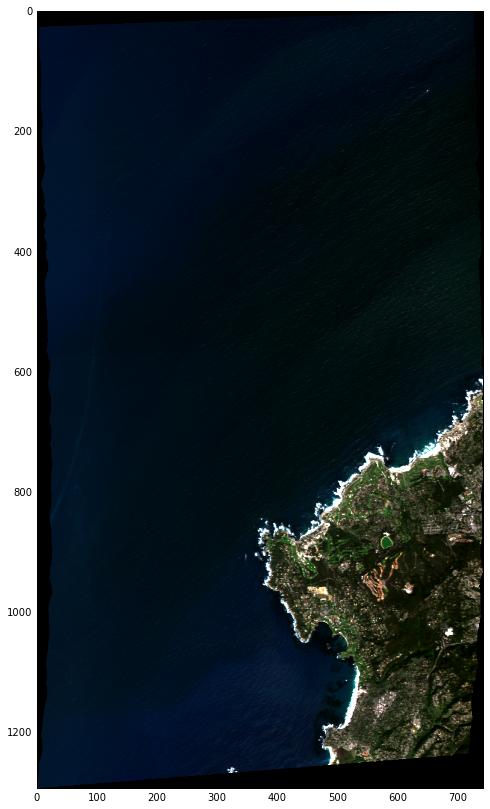

In [246]:
#plot true color im09
spy.imshow(images[0], truecolor, stretch = .005 ,figsize=(8,16))
plt.show()

Here's the same image displayed in false color:

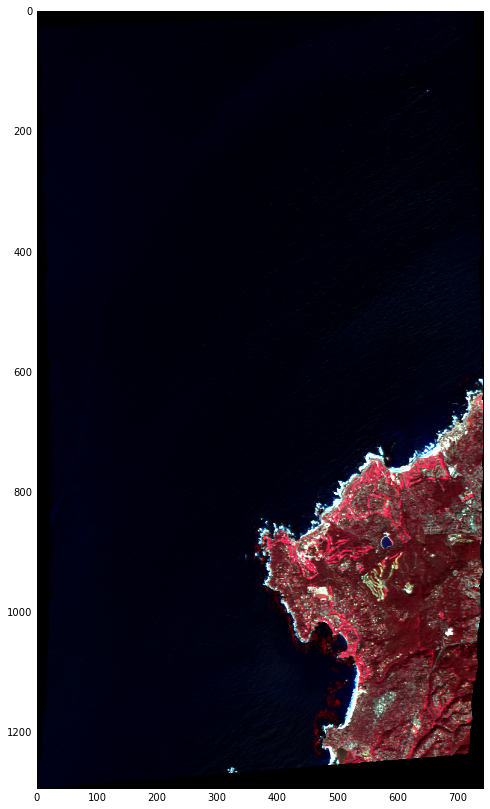

In [247]:
#plot false color im09
spy.imshow(images[0], falsecolor1, stretch = .005 ,figsize=(8,16))
plt.show()

As you can see, the ocean is still blue, but vegetation now looks red.  This is because the red channel of the image is displaying an infrared band, and vegetation tends to have high reflectance in the infrared part of the spectrum.  You may notice red splotches just off the coast - those are the kelp forests!

In [248]:
# grab the necessary bands to pick out the kelp
i = 0
kelpgreen = images[i].read_band(23).astype(float)
red = images[i].read_band(33).astype(float)
nir = images[i].read_band(39).astype(float)
nir2 = images[i].read_band(59).astype(float)
swir1 = images[i].read_band(78).astype(float)
swir2 = images[i].read_band(137).astype(float)
NDVI = ((nir - red)/(nir + red))
NDVI[np.isnan(NDVI)] = -1
ratio = nir2/nir
kelp = (NDVI > .6) & (100 < swir1) & (swir1 < 600) & (kelpgreen > 70) & (ratio < .8)

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


Here's the same image but in a different false color combination, along with the kelp selection

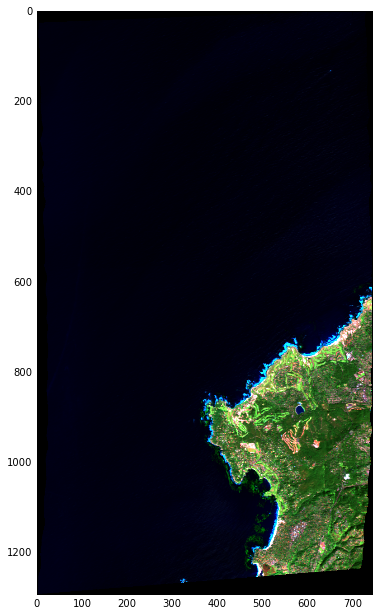

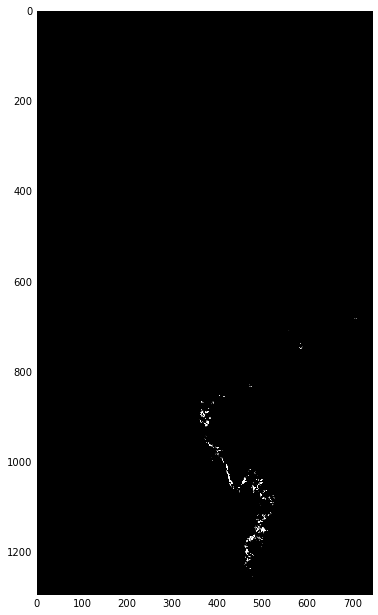

In [249]:
#plot false color im09 with kelp

spy.imshow(images[0], falsecolor2, stretch = .005 ,figsize=(6,12))
plt.show()
spy.imshow(kelp ,figsize=(6,12))
plt.show()

As you can see, the white areas in the second (binary) image coincide with the bright green areas off the coast in the first image. Again, these are the kelp forests.  This false color image uses a shortwave infrared band for the red channel, a near-infrared band for the green channel, and a green band for the blue channel.  This results to a color scheme somewhat similar to a true-color image, with vegetation showing up as green and water as blue.  However, the vegetation tends to 'pop' more, allowing us to see the kelp. 

In [251]:
# grab the necessary bands from im10 to pick out the kelp
i = 1
kelpgreen = images[i].read_band(23).astype(float)
red = images[i].read_band(33).astype(float)
nir = images[i].read_band(39).astype(float)
nir2 = images[i].read_band(59).astype(float)
swir1 = images[i].read_band(78).astype(float)
swir2 = images[i].read_band(137).astype(float)
NDVI = ((nir - red)/(nir + red))
NDVI[np.isnan(NDVI)] = -1
ratio = nir2/nir
kelp = (NDVI > .6) & (100 < swir1) & (swir1 < 600) & (kelpgreen > 70) & (ratio < .8)

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


Here's another example of the kelp selection criteria.  This is an image of Santa Cruz, CA, taken on the same date.

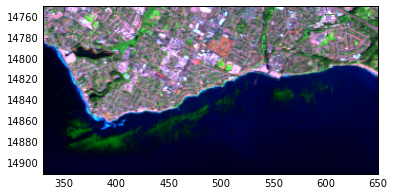

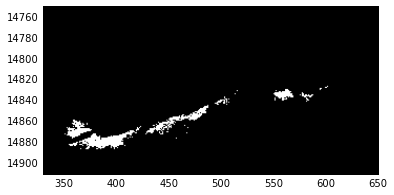

In [253]:
#plot false color im10 with kelp
xlim = (330,650)
ylim = (14910,14750)
spy.imshow(images[1], falsecolor2, stretch = .005 ,figsize=(6,12),fignum=0)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()
spy.imshow(kelp,figsize=(6,12),fignum=1)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

Again, the criteria do a great job of picking out the kelp.

### Endmember Analysis

Here I've plotted the spectra of several identified pixels taken from the imagery.  It's easy to see that all three kelp pixels are very similar, and together very different from the land, water, and cloud. 

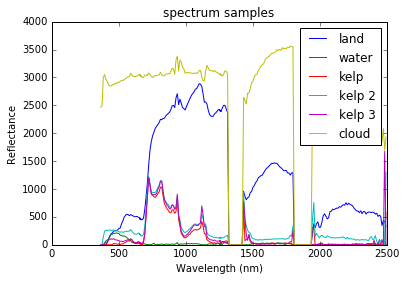

In [279]:
land = images[0].read_pixel(1000,500)
water = images[0].read_pixel(1000,300)
kelp = images[0].read_pixel(1150,500)
cloud = images[3].read_pixel(5875,1062)

plt.plot(images[0].bands.centers, land,label='land')
plt.plot(images[0].bands.centers, water,label='water')
plt.plot(images[0].bands.centers, kelp, label='kelp 1')

plt.plot(images[0].bands.centers, images[3].read_pixel(6535,671), label='kelp 2')
plt.plot(images[0].bands.centers, images[1].read_pixel(14880,379), label='kelp 3')
plt.plot(images[0].bands.centers, cloud, label='cloud')
plt.title('spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()
plt.show()

The coordinate data that I have is in a format called UTM, which stands for Universal Transverse Mercator, as opposed to latitude and longitude.  UTM is less intuitive, but has one big advantage: its units are in meters. Most helpfully, the y, or northing, coordinate of a point is always simply the number of meters that point lies north of the equator.  

As I mentioned earlier, my training data will come from endmembers at the north and south ends of the California coast.  4180000 will be the northern threshold (San Francisco), and 3820000 the southern (Point Conception).

In [265]:
n_thresh = 4180000
s_thresh = 3820000

In [269]:
bull_kelp_endmembers = pixels[coords[:,1] > n_thresh]
giant_kelp_endmembers = pixels[coords[:,1] < s_thresh]
print len(bull_kelp_endmembers)
print len(giant_kelp_endmembers)

2958
5990


This is incredibly exciting.  When I did my research over the summer, I only had about 30 training endmembers in each class.  Now, from only 4 images, I have almost 3000 bull kelp endmembers and 6000 giant kelp endmembers. 

Here are some sample spectra from the giant kelp:

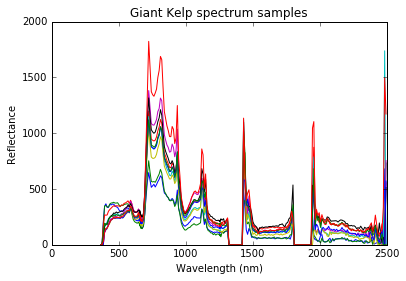

In [273]:
bands = images[0].bands.centers
for spectrum in giant_kelp_endmembers[:1000:100]:
    plt.plot(bands, spectrum)
plt.title('Giant Kelp spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.show()

Here are some sample spectra from the bull kelp:

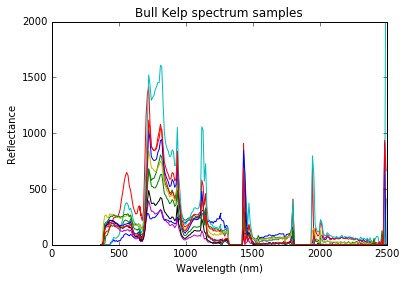

In [275]:
for spectrum in bull_kelp_endmembers[:1000:100]:
    plt.plot(bands, spectrum)
plt.title('Bull Kelp spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylim(0,2000)
plt.show()

All the spectra in these two images seem to have the same general shape, which is consistent with the idea that the two species are very spectrally similar.  However, there seem to be some differences in the visible spectrum (400-700 nm).  Most of the giant kelp seem to have a positive slope in the spectrum between 400 and 500 nm, while most of the bull kelp tend to have a negative slope in the same region.  This is likely not enough to distinguish between the two species, but rather suggests that they could very well be distinguishable with machine learning.